In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_artist.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_genres.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_w_genres.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_year.csv


In [2]:
spotify=pd.read_csv("../input/spotify-dataset-19212020-160k-tracks/data.csv")

In [3]:
spotify.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [4]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

X=spotify.copy().dropna()
y = X.pop('popularity')
artists = X['artists']
features_num =['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness'
              ,'mode','speechiness','tempo','valence']
preprocessor = make_column_transformer(
    (StandardScaler(), features_num))
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))


Input shape: [12]


In [6]:
from sklearn.ensemble import RandomForestClassifier
for c in X.columns[X.dtypes=='object']:
    X[c]=X[c].factorize()[0]
clf=RandomForestClassifier()
clf.fit(X,y)


RandomForestClassifier()

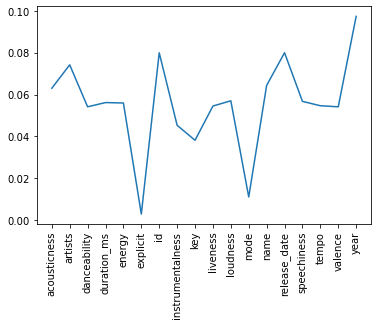

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(clf.feature_importances_)
plt.xticks(np.arange(X.shape[1]),X.columns.tolist(),rotation=90);

In [8]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
my_model_1 = XGBRegressor(random_state=0)
my_model_1.fit(X_train,y_train)
predictions_1 = my_model_1.predict(X_valid)
mae_1 = mean_absolute_error(predictions_1,y_valid)

In [9]:
mae_1

0.1033764610357554

**Fine Tuning**

In [10]:
model_2 = XGBRegressor(random_state=0,n_estimators=1000,learning_rate=0.05)
model_2.fit(X_train,y_train) 
predictions_2 = model_2.predict(X_valid) 
mae_2 = mean_absolute_error(predictions_2,y_valid) 
mae_2

0.10191418666577733

In [11]:
train_mae_list=[0.1]
valid_mae_list=[0.1]
for n_estim in range (100,1000,100):
    model = XGBRegressor(random_state=0,n_estimators=n_estim,learning_rate=0.05)
    model.fit(X_train,y_train)
    train_predictions=model.predict(X_train)
    valid_predictions=model.predict(X_valid)
    
    train_mae=mean_absolute_error(train_predictions,y_train)
    valid_mae=mean_absolute_error(valid_predictions,y_valid)
    
    train_mae_list.append(train_mae)
    valid_mae_list.append(valid_mae)


<function matplotlib.pyplot.show(*args, **kw)>

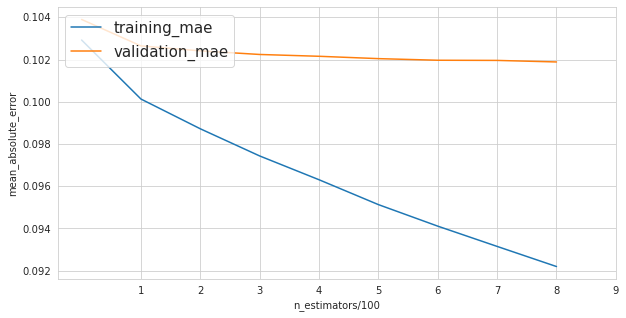

In [12]:

plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
plt.plot(train_mae_list[1:],label="training_mae")
plt.plot(valid_mae_list[1:],label="validation_mae")
plt.legend(loc="upper left",prop={'size':15})
plt.xticks(range(1,10))
plt.xlabel("n_estimators/100")
plt.ylabel("mean_absolute_error")
plt.show

In [13]:
train_mae_list

[0.1,
 0.10292797693400321,
 0.10013100165493015,
 0.09872165670063664,
 0.0974350955715285,
 0.09630798158351148,
 0.09512977971022996,
 0.09410961743866247,
 0.09314953441085964,
 0.09219632616539565]

In [ ]:
from sklearn.model_selection import GridSearchCV
model_3 = XGBRegressor()
parameters = {
 "learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators"    : [300] }

model_3_grid = GridSearchCV(model_3,
                        parameters,
                        cv = 2,
                        n_jobs = 2,
                        verbose=True)

model_3_grid.fit(X_train,
         y_train)

print(model_3_grid.best_score_)
print(model_3_grid.best_params_)

Fitting 2 folds for each of 3840 candidates, totalling 7680 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.2min
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 22.1min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 48.6min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 82.1min
